In [1]:
!python3 --version

Python 3.10.14


In [2]:
!pip install pyqubo openjij

In [7]:
!which pip

/Users/aaaaa/.pyenv/versions/3.10.14/bin/pip


In [8]:
from pyqubo import Array, Placeholder, solve_ising, Constraint ,solve_qubo, SubH
import re

In [9]:
# resourceに番号を割り当てる
def assign_resource_num(resource):
    resource_num = {}
    cnt = 0
    for i in resource:
        for j in resource[i]:
            resource_num[j] = cnt
            cnt += 1
    return resource_num

In [3]:
# resource_m = {'R0':['m11','m12'],'R1':['m21','m22','m23'],'R2':['m31','m32','m33','m34','m35','m36']}
# resource_t = {'R0':['t11','t21','t31','t41'],'R1':['t12','t22','t32','t42'],
#               'R2':['t13','t23','t33','t43']}

# place = [['p11','p12','p13','p14'],['p21','p22','p23','p24'],['p31','p32','p33','p34'],['p41','p42','p43','p44']]

# job = [['t11','t12','t13'],['t21','t22','t23'],['t31','t32','t33'],['t41','t42','t43']]

# machine_processing_time = {'m11':1,'m12':2,'m21':3,'m22':1,'m23':2,'m31':1,'m32':3,'m33':2,
#                           'm34':2,'m35':1,'m36':2}

# machine_cost = {'m11':10,'m12':14,'m21':13,'m22':10,'m23':10,'m31':12,'m32':10,'m33':9,
#                           'm34':12,'m35':14,'m36':15}

# import random

# # Machine keys
# machine_keys = ['m11', 'm12', 'm21', 'm22', 'm23', 'm31', 'm32', 'm33', 'm34', 'm35', 'm36']

# # Generate random processing times and costs
# machine_processing_time = {key: random.randint(1, 3) for key in machine_keys}  
# machine_cost = {key: random.randint(9, 15) for key in machine_keys}  

# print("Machine Processing Time:", machine_processing_time)
# print("Machine Cost:", machine_cost)

# resource_num = assign_resource_num(resource_m)

# resource_num

In [10]:
# スケジューリング問題のjobリソースを生成
def generate_jobs_and_resources(num_jobs):
    resource_t = {'R0': [], 'R1': [], 'R2': []}
    place = []
    job = []

    for i in range(1, num_jobs + 1):
        t11 = f't{i}1'
        t12 = f't{i}2'
        t13 = f't{i}3'

        job.append([t11, t12, t13])

        resource_t['R0'].append(t11)
        resource_t['R1'].append(t12)
        resource_t['R2'].append(t13)

        place.append([f'p{i}1', f'p{i}2', f'p{i}3', f'p{i}4'])

    return resource_t, place, job

# ジョブ数を指定して生成
num_jobs = 15
resource_t, place, job = generate_jobs_and_resources(num_jobs)

# resource_m = {'R0':['m11','m12'],'R1':['m21','m22','m23'],'R2':['m31','m32','m33','m34','m35','m36']}
resource_m = {'R0':['m11','m12'],'R1':['m21','m22'],'R2':['m31','m32']}
machine_processing_time = {'m11':1,'m12':2,'m21':3,'m22':1,'m23':2,'m31':1,'m32':3,'m33':2,
                        'm34':2,'m35':1,'m36':2}

machine_cost = {'m11':10,'m12':14,'m21':13,'m22':10,'m23':10,'m31':12,'m32':10,'m33':9,
                        'm34':12,'m35':14,'m36':15}

resource_num = assign_resource_num(resource_m)

resource_num


{'m11': 0, 'm12': 1, 'm21': 2, 'm22': 3, 'm31': 4, 'm32': 5}

In [11]:
# トランジションに番号を割り当てる
transition_num = {}
cnt = 0
for i in job:
    for j in i:
        transition_num[j] = cnt
        cnt += 1
transition_num

{'t11': 0,
 't12': 1,
 't13': 2,
 't21': 3,
 't22': 4,
 't23': 5,
 't31': 6,
 't32': 7,
 't33': 8,
 't41': 9,
 't42': 10,
 't43': 11,
 't51': 12,
 't52': 13,
 't53': 14,
 't61': 15,
 't62': 16,
 't63': 17,
 't71': 18,
 't72': 19,
 't73': 20,
 't81': 21,
 't82': 22,
 't83': 23,
 't91': 24,
 't92': 25,
 't93': 26,
 't101': 27,
 't102': 28,
 't103': 29,
 't111': 30,
 't112': 31,
 't113': 32,
 't121': 33,
 't122': 34,
 't123': 35,
 't131': 36,
 't132': 37,
 't133': 38,
 't141': 39,
 't142': 40,
 't143': 41,
 't151': 42,
 't152': 43,
 't153': 44}

In [12]:
t_num = len(transition_num)
r_num = len(resource_num)
time = 30
x = Array.create('x', (time,t_num,r_num), 'BINARY') # binaryの宣言

## Binary変数
x(時間,トランジション,マシーン)

In [13]:
def cal_min_processing(resource_m, machine_processing_time):
    """
    各リソースマシーンのprocessing timeの最小を求める
    Args:
        resource_m : リソースマシーンの辞書型
        machine_processing_time : マシーンの処理時間の辞書型

    Returns:
        R0,R1,R2それぞれのprocessing timeの最小時間を求める
    """
    min_m_time = []
    for idx,v in enumerate(resource_m):
        _min = 10000
        for i in resource_m[v]:
            _min = min(_min,machine_processing_time[i])
        min_m_time.append(_min)
    return min_m_time

In [14]:
def cal_max_processing(resource_m, machine_processing_time):
    """
    各リソースマシーンのprocessing timeの最大を求める
    Args:
        resource_m : リソースマシーンの辞書型
        machine_processing_time : マシーンの処理時間の辞書型

    Returns:
        R0,R1,R2それぞれのprocessing timeの最大時間を求める
    """
    max_m_time = []
    for idx,v in enumerate(resource_m):
        _min = -1
        for i in resource_m[v]:
            _min = max(_min,machine_processing_time[i])
        max_m_time.append(_min)
    return max_m_time

In [15]:
def calc_upper_limit(step, jobs, limit_time, _max):
    """
    現在のステップにおける処理時間の上限時間の計算
    Args:
        step : 現在のステップ
        jobs : 各jobのタスクのリスト
        limit_time : 制限時間
        _max : 各リソースマシーンのprocessing timeの最大値のリスト(max_list)

    Returns:
    現在のステップの上限時間を求める
    """
    p_time = 0
    for job in jobs: #jobはstr型
        if len(job) >= 4:
            if int(job[3]) >= step:
                p_time += _max[int(job[3])-1]
        elif int(job[2]) >= step:
                p_time += _max[int(job[2])-1]
    return limit_time - p_time

In [16]:
# 各トランジションの処理時間の最大・最小値を求める
range_trantision_ptime = {}
min_list = cal_min_processing(resource_m, machine_processing_time)
max_list = cal_max_processing(resource_m, machine_processing_time)

#各タスクの下限と上限時間
#'t11': [0, 22] t11は最低0秒、最高22秒で開始しなければならない
for idx, j in enumerate(job):
    for i in range(len(j)):
        range_time = []
        lb = sum(min_list[0:i]) if i != 0 else 0
        range_time.append(lb)
        ub = calc_upper_limit(i+1, j, time, max_list)
        range_time.append(ub)
        range_trantision_ptime[j[i]] = range_time
range_trantision_ptime

{'t11': [0, 22],
 't12': [1, 24],
 't13': [2, 27],
 't21': [0, 22],
 't22': [1, 24],
 't23': [2, 27],
 't31': [0, 22],
 't32': [1, 24],
 't33': [2, 27],
 't41': [0, 22],
 't42': [1, 24],
 't43': [2, 27],
 't51': [0, 22],
 't52': [1, 24],
 't53': [2, 27],
 't61': [0, 22],
 't62': [1, 24],
 't63': [2, 27],
 't71': [0, 22],
 't72': [1, 24],
 't73': [2, 27],
 't81': [0, 22],
 't82': [1, 24],
 't83': [2, 27],
 't91': [0, 22],
 't92': [1, 24],
 't93': [2, 27],
 't101': [0, 22],
 't102': [1, 24],
 't103': [2, 27],
 't111': [0, 22],
 't112': [1, 24],
 't113': [2, 27],
 't121': [0, 22],
 't122': [1, 24],
 't123': [2, 27],
 't131': [0, 22],
 't132': [1, 24],
 't133': [2, 27],
 't141': [0, 22],
 't142': [1, 24],
 't143': [2, 27],
 't151': [0, 22],
 't152': [1, 24],
 't153': [2, 27]}

## H_firing

In [17]:
#制約
H_firing = 0.0
for idx, j in enumerate(job):
    for i in range(len(j)):
        sigma_h_firing = 0.0
        for r in resource_m['R'+str(i)]:
            lb = range_trantision_ptime[j[i]][0]
            ub = range_trantision_ptime[j[i]][1]
            for k in range(lb,ub):
                t = transition_num['t'+str(idx+1)+str(i+1)]
                sigma_h_firing += x[k,t,resource_num[r]]
        H_firing += Constraint((1-sigma_h_firing)**2,label="one_fired_t{}{}{}".format(idx+1,i+1,resource_num[r]))

## H_conflict

In [18]:
#制約
H_conflict = 0.0

for i in range(len(resource_m)):
    for r in resource_m['R'+str(i)]:
        for j1 in range(len(job)):
            t1 = transition_num[job[j1][i]]
            for j2 in range(len(job)):
                t2 = transition_num[job[j2][i]]
                if j1 != j2:
                    lb = range_trantision_ptime[job[j1][i]][0]
                    ub = range_trantision_ptime[job[j1][i]][1]
                    for k1 in range(lb,ub):
                        max_limit = k1 + machine_processing_time[r]
                        if max_limit > 10:
                            max_limit = 10
                        for k2 in range(k1,max_limit):
                            if k2 < range_trantision_ptime[job[j2][i]][1]:
                                H_conflict += Constraint((x[k1,t1,resource_num[r]])*(x[k2,t2,resource_num[r]]), label="conflict{}".format(t1))


## H_precedence

In [19]:
#制約
H_precedence = 0.0

for idx, j in enumerate(job):
    for i in range(len(j)):
        lb = range_trantision_ptime[j[i]][0]
        ub = range_trantision_ptime[j[i]][1]
        for r1 in resource_m['R'+str(i)]:
            if i+1 < len(j):
                for r2 in resource_m['R'+str((i+1))]:
                    t1 = transition_num['t'+str(idx+1)+str(i+1)]
                    t2 = transition_num['t'+str(idx+1)+str(i+2)]
                    print('t'+str(idx+1)+str(i+2))
                    for k1 in range(lb,ub):
                        fd = k1 + machine_processing_time[r1]
                        
                        for k2 in range(fd):
                            # if k1 == 5 and k2 == 3:
                            print(k1,t1,t2,k2,resource_num[r1],resource_num[r2])
                            H_precedence += Constraint((x[k1,t1,resource_num[r1]])*(x[k2,t2,resource_num[r2]]), 
                                                       label="precedence{}{}{}{}".format(k1,t1,k2,t2))

t12
0 0 1 0 0 2
1 0 1 0 0 2
1 0 1 1 0 2
2 0 1 0 0 2
2 0 1 1 0 2
2 0 1 2 0 2
3 0 1 0 0 2
3 0 1 1 0 2
3 0 1 2 0 2
3 0 1 3 0 2
4 0 1 0 0 2
4 0 1 1 0 2
4 0 1 2 0 2
4 0 1 3 0 2
4 0 1 4 0 2
5 0 1 0 0 2
5 0 1 1 0 2
5 0 1 2 0 2
5 0 1 3 0 2
5 0 1 4 0 2
5 0 1 5 0 2
6 0 1 0 0 2
6 0 1 1 0 2
6 0 1 2 0 2
6 0 1 3 0 2
6 0 1 4 0 2
6 0 1 5 0 2
6 0 1 6 0 2
7 0 1 0 0 2
7 0 1 1 0 2
7 0 1 2 0 2
7 0 1 3 0 2
7 0 1 4 0 2
7 0 1 5 0 2
7 0 1 6 0 2
7 0 1 7 0 2
8 0 1 0 0 2
8 0 1 1 0 2
8 0 1 2 0 2
8 0 1 3 0 2
8 0 1 4 0 2
8 0 1 5 0 2
8 0 1 6 0 2
8 0 1 7 0 2
8 0 1 8 0 2
9 0 1 0 0 2
9 0 1 1 0 2
9 0 1 2 0 2
9 0 1 3 0 2
9 0 1 4 0 2
9 0 1 5 0 2
9 0 1 6 0 2
9 0 1 7 0 2
9 0 1 8 0 2
9 0 1 9 0 2
10 0 1 0 0 2
10 0 1 1 0 2
10 0 1 2 0 2
10 0 1 3 0 2
10 0 1 4 0 2
10 0 1 5 0 2
10 0 1 6 0 2
10 0 1 7 0 2
10 0 1 8 0 2
10 0 1 9 0 2
10 0 1 10 0 2
11 0 1 0 0 2
11 0 1 1 0 2
11 0 1 2 0 2
11 0 1 3 0 2
11 0 1 4 0 2
11 0 1 5 0 2
11 0 1 6 0 2
11 0 1 7 0 2
11 0 1 8 0 2
11 0 1 9 0 2
11 0 1 10 0 2
11 0 1 11 0 2
12 0 1 0 0 2
12 0 1 1 0 2
12 0 1 2

## H_resourceCost

In [20]:
#目的関数
H_resourceCost = 0.0

for i in range(len(resource_m)):
    for r in resource_m['R'+str(i)]:
        r_num = resource_num[r]
        rc = machine_cost[r]
        fd = machine_processing_time[r]
        for j in range(len(job)):
            lb = range_trantision_ptime['t'+str(j+1)+str(i+1)][0]
            ub = range_trantision_ptime['t'+str(j+1)+str(i+1)][1]
            t = transition_num['t'+str(j+1)+str(i+1)]
            for k in range(lb,ub):
                H_resourceCost += rc*fd*x[k,t,r_num]

## H_waitingTime

In [21]:
#目的関数
H_waitingTime = 0.0

for j in range(len(job)):
    for i in range(len(job[j])-1):
        #後のタスク
        lb1 = range_trantision_ptime['t'+str(j+1)+str(i+2)][0]
        ub1 = range_trantision_ptime['t'+str(j+1)+str(i+2)][1]
        t1 = transition_num['t'+str(j+1)+str(i+2)]
        #前のタスク
        lb2 = range_trantision_ptime['t'+str(j+1)+str(i+1)][0]
        ub2 = range_trantision_ptime['t'+str(j+1)+str(i+1)][1]
        t2 = transition_num['t'+str(j+1)+str(i+1)]
        for k1 in range(lb1,ub1):
            for r1 in resource_m['R'+str(i+1)]:
                r_num1 = resource_num[r1]
                for k2 in range(lb2,ub2):
                    for r2 in resource_m['R'+str(i)]:
                        fd = k2 + machine_processing_time[r2]
                        r_num2 = resource_num[r2]
                        if k1 - fd >= 0:
                            H_waitingTime += (k1 - fd) * x[k2,t2,r_num2] * x[k1,t1,r_num1]
                            

## PyQUBO

In [22]:
# ハミルトニアンを構築
A = Placeholder("A")
B = Placeholder("B")
C = Placeholder("C")
D = Placeholder("D")
E = Placeholder("E")

H = SubH(A*H_firing, "SubH1") + SubH(B*H_conflict, "SubH2") + SubH(C*H_precedence, "SubH3") + D*H_resourceCost + E*H_waitingTime

In [23]:
# モデルをコンパイル
model = H.compile()

In [24]:
#PyQUBOの場合
feed_dict = {"A": 200.0, "B": 140.0, "C": 30.0, "D": 1, "E": 0.5}

In [25]:
# QUBOを作成
bqm = model.to_bqm(feed_dict=feed_dict)

In [26]:
# QUBOの変数数（量子ビットの数）を確認
num_qubits = len(bqm.variables)
print(f"Number of qubits: {num_qubits}")

Number of qubits: 2190


## PyQUBOからOpenJij

In [3]:
import openjij as oj

In [27]:
# アニーリング回数
num_iterations = 100

# QUBOを辞書形式に変換
qubo_dict = bqm.to_qubo()[0]

# OpenJijのSamplerを使用してQUBOを解く
sampler = oj.SASampler()

response = sampler.sample_qubo(qubo_dict, num_reads=num_iterations)

# サンプリング結果をデコード
decoded_samples = model.decode_sampleset(response, feed_dict=feed_dict)

# 最良のサンプルを選択
best_sample = min(decoded_samples, key=lambda x: x.energy)
num_broken = len(best_sample.constraints(only_broken=True))

In [28]:
# 最良のサンプルの各サブハミルトニアンの値を計算する関数
def calculate_subh_energy(subh, sample, feed_dict):
    """
    各サブハミルトニアンの計算
    Args:
        subh: サブハミルトニアン
        sample: 最良のサンプル
        feed_dict: ハイパーパラメータ
    Returns:
        ハミルトニアンの各項のエネルギーを計算する
    """
    subh_model = subh.compile()
    subh_qubo, subh_offset = subh_model.to_qubo(feed_dict=feed_dict)
    subh_energy = sum(subh_qubo.get((v, v), 0) * sample[v] for v in sample) #一次項の計算
    for (v1, v2), coeff in subh_qubo.items(): #二次の項の計算
        if v1 != v2:
            subh_energy += coeff * sample[v1] * sample[v2]
    return subh_energy + subh_offset

In [29]:
#目的関数のエネルギー
resource_cost = calculate_subh_energy(H_resourceCost, best_sample.sample, feed_dict)
waiting_time = calculate_subh_energy(H_waitingTime, best_sample.sample, feed_dict)

In [30]:
# デコードされた解を表示
print("Decoded Solution:")
for variable, value in best_sample.sample.items():
    print(f"{variable}: {value}")

Decoded Solution:
x[12][39][0]: 0
x[6][20][4]: 0
x[0][26][4]: 0
x[7][17][5]: 0
x[0][9][1]: 0
x[4][15][1]: 0
x[7][14][5]: 0
x[10][14][4]: 0
x[10][27][0]: 1
x[17][25][2]: 0
x[14][4][2]: 0
x[4][38][4]: 0
x[11][26][4]: 0
x[6][6][1]: 0
x[0][25][3]: 0
x[17][19][3]: 0
x[13][16][3]: 0
x[5][8][4]: 0
x[0][17][5]: 0
x[20][4][2]: 0
x[7][38][5]: 0
x[23][5][4]: 0
x[0][19][3]: 0
x[1][3][1]: 0
x[25][44][5]: 0
x[18][2][4]: 0
x[0][1][3]: 0
x[0][21][0]: 0
x[8][1][3]: 0
x[2][19][3]: 0
x[2][26][5]: 0
x[6][24][1]: 0
x[14][5][4]: 0
x[16][23][4]: 0
x[25][20][4]: 0
x[0][23][4]: 0
x[0][23][5]: 0
x[22][25][2]: 0
x[15][25][2]: 0
x[13][18][1]: 0
x[16][1][2]: 0
x[18][0][0]: 0
x[10][30][0]: 0
x[15][7][2]: 0
x[16][29][5]: 0
x[0][30][0]: 0
x[10][42][1]: 0
x[10][16][3]: 0
x[20][6][1]: 0
x[14][34][2]: 0
x[0][30][1]: 0
x[0][22][3]: 0
x[5][16][2]: 0
x[1][10][2]: 0
x[16][4][2]: 0
x[0][28][3]: 0
x[11][12][0]: 0
x[15][28][2]: 0
x[12][29][5]: 0
x[1][23][5]: 0
x[0][19][2]: 0
x[0][33][1]: 0
x[20][42][1]: 0
x[10][26][5]: 0
x[10]

In [33]:
print("\nEnergy:")
print(best_sample.energy)

print(best_sample.constraints(only_broken=True))
print("number of broken constarint = {}".format(num_broken))


Energy:
876.0
{}
number of broken constarint = 0


In [34]:
keys = [k for k, v in best_sample.sample.items() if v == 1]

In [35]:
# 正規表現
def extractVariable(s):  
    literal = re.split('[\[\]]', s)
    while '' in literal:
        literal.remove('')       
    return literal

In [36]:
ans = []

for k in keys:
    ans.append(extractVariable(k))

sort_ans = list(range(len(ans)))

for i in ans:
    sort_ans[int(i[2])] = i

In [37]:
from collections import OrderedDict

def calc_machine_cost(machine_processing_time,ans):
    ans_order = OrderedDict()
    _cnt = 0

    for idx in machine_processing_time.keys():
        ans_order[idx] = _cnt
        _cnt += 1

    ans_list = list(ans_order.keys())

    sum_cost = 0
    for i in ans:
        sum_cost += machine_cost[ans_list[int(i[3])]]
    return sum_cost

In [38]:
def calc_processing_time(machine_processing_time,ans):
    ans_order = OrderedDict()
    _cnt = 0

    for idx in machine_processing_time.keys():
        ans_order[idx] = _cnt
        _cnt += 1

    ans_list = list(ans_order.keys())

    max_time = 0
    for i in range(len(ans)):
        max_time = max(max_time,int(ans[i][1])+machine_processing_time[ans_list[int(ans[i][3])]])
    return max_time

In [39]:
machine_cost = calc_machine_cost(machine_processing_time, sort_ans)
processing_time = calc_processing_time(machine_processing_time, sort_ans)

print("-"*30)
print("Machine Cost : {}".format(machine_cost))
print("-"*30)
print("Processing Time : {}".format(processing_time))
print("-"*30)
print("Resource Cost : {}".format(resource_cost))
print("-"*30)
print("Waiting Time : {}".format(waiting_time))
print("-"*30)

------------------------------
Machine Cost : 473
------------------------------
Processing Time : 28
------------------------------
Resource Cost : 657.0
------------------------------
Waiting Time : 138.0
------------------------------


In [40]:
subH_list = ['SubH1','SubH2','SubH3']
is_feasible = True

for i in subH_list:
    if best_sample.subh[i] != 0:
        is_feasible = False
if is_feasible:
    print('Feasible!!')
else:
    if best_sample.subh[i] != 0:
        print("["+str(i)+"]=",best_sample.subh[i])

[SubH3]= 150.0


## データをcsvに保存する

In [187]:
import csv
import os
from datetime import datetime

now = datetime.now()
timestamp = now.strftime('%Y-%m-%d')

# 保存するファイル名
csv_filename = f'./search/t_30/0901/{timestamp}_patt30_job{num_jobs}.csv' #任意のファイル名

# CSVファイルが存在するかどうかを確認
file_exists = os.path.isfile(csv_filename)

constraint_error = best_sample.constraints(only_broken=True)
feasible = 0 if is_feasible else constraint_error 
#制約違反起こしてない場合もある、そのときはサブハミルトニアンが0ではない場合があるので出力する様にしている

# データをリストのリストとして準備
# data = [[num_iterations, machine_cost, processing_time, resource_cost, wating_time, feasible]]
data = [[num_iterations, resource_cost, waiting_time, feasible]]

# ファイルが存在しない場合はヘッダーを追加
if not file_exists:
    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        # writer.writerow(['iteration', 'machine_cost', 'processing_time', 'resource_cost', 'wating_time','feasible'])
        writer.writerow(['iteration', 'resource_cost', 'waiting_time','feasible'])
        writer.writerows(data)
else:
    # ファイルが存在する場合は追記
    with open(csv_filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(data)

## データに対して平均と分散をplot

In [41]:
import pandas as pd
import numpy as np
import re
import glob
import matplotlib.pyplot as plt

# 全パターンのファイルパスを取得
file_paths = glob.glob("../search/t_30/0901/2024-09-01_patt*_job15.csv") #任意のファイル名
# file_paths = glob.glob("./search/t_30/2024-08-22_patt*_job15.csv")

# 結果を保存するリスト
all_results = []

# 各ファイルに対して処理を適用
for file_path in file_paths:
    # ファイル名からパターン番号を抽出
    patt_number = int(re.search(r'patt(\d+)', file_path).group(1))
    
    # CSVファイルを読み込む
    df = pd.read_csv(file_path)
    
    # feasibleが0の行のみを選択（文字列'0'も含む）
    df_feasible_0 = df[df['feasible'].astype(str) == '0']
    
    # resource_cost, wating_time, feasible列を数値に変換
    df_feasible_0['resource_cost'] = pd.to_numeric(df_feasible_0['resource_cost'], errors='coerce')
    df_feasible_0['waiting_time'] = pd.to_numeric(df_feasible_0['waiting_time'], errors='coerce')
    df_feasible_0['feasible'] = pd.to_numeric(df_feasible_0['feasible'], errors='coerce')
    
    # 数値に変換できなかったデータを除外
    df_feasible_0 = df_feasible_0.dropna(subset=['resource_cost', 'waiting_time', 'feasible'])
    
    # iteration毎にresource_costとwating_timeの平均と分散を計算
    summary = df_feasible_0.groupby('iteration').agg(
        mean_resource_cost=('resource_cost', 'mean'),
        var_resource_cost=('resource_cost', 'var'),
        mean_waiting_time=('waiting_time', 'mean'),
        var_waiting_time=('waiting_time', 'var'),
    ).reset_index()
    
    # パターン番号を追加
    summary['patt'] = patt_number
    
    # パターン番号とiterationを結合して新しいラベルを作成
    summary['label'] = summary['patt'].astype(str) + "_" + summary['iteration'].astype(str)
    
    # リストに追加
    all_results.append(summary)
    
# 全パターンの結果を結合
final_df = pd.concat(all_results)

# パターンごとに結果をソート
final_df = final_df.sort_values(by=['patt', 'iteration'])

final_df

/var/folders/jk/qk90jfkj31l89klf8w4dfwnh0000gn/T/ipykernel_7996/700879641.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feasible_0['resource_cost'] = pd.to_numeric(df_feasible_0['resource_cost'], errors='coerce')
/var/folders/jk/qk90jfkj31l89klf8w4dfwnh0000gn/T/ipykernel_7996/700879641.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feasible_0['waiting_time'] = pd.to_numeric(df_feasible_0['waiting_time'], errors='coerce')
/var/folders/jk/qk90jfkj31l89klf8w4dfwnh0000gn/T/ipykernel_7996/7008

,iteration,mean_resource_cost,var_resource_cost,mean_waiting_time,var_waiting_time,patt,label
0,100,822.900000,2585.673684,77.350000,374.344737,1,1_100
0,100,859.000000,5647.222222,15.736842,60.649123,2,2_100
0,100,857.300000,2874.326316,3.200000,7.747368,3,3_100
0,100,846.600000,3450.568421,0.700000,1.589474,4,4_100
0,100,838.950000,1981.102632,0.350000,0.344737,5,5_100
0,100,816.350000,2053.502632,0.000000,0.000000,6,6_100
0,100,656.076923,527.743590,89.307692,474.230769,7,7_100
0,100,668.777778,738.444444,31.222222,149.194444,8,8_100
0,100,647.692308,1429.730769,11.307692,76.897436,9,9_100
0,100,648.400000,762.114286,3.533333,10.980952,10,10_100


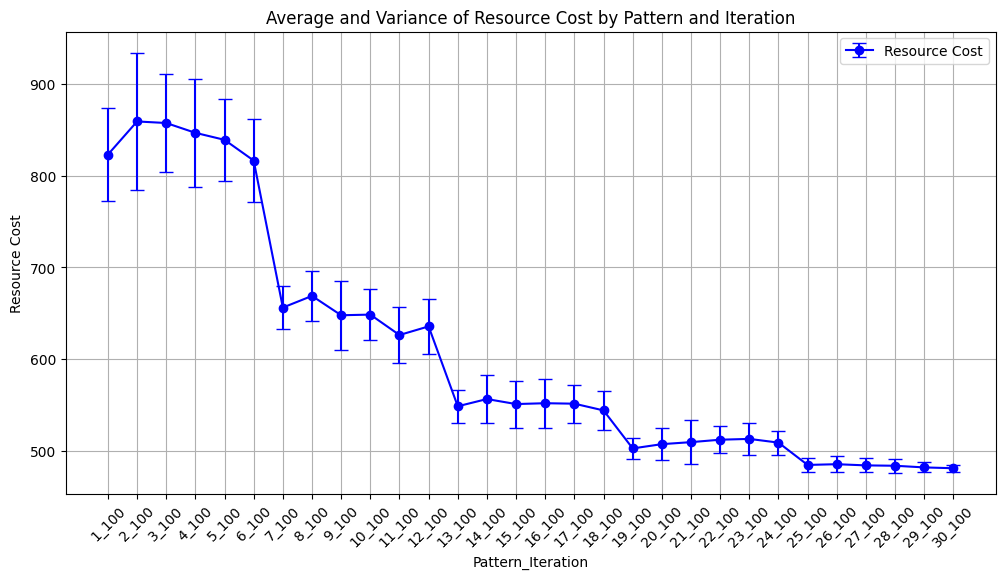

In [42]:
# resource_costをプロット
plt.figure(figsize=(12, 6))

# 分散のエラーバーを計算
err_rc = np.sqrt(final_df['var_resource_cost'])

plt.errorbar(final_df['label'], final_df['mean_resource_cost'], 
             yerr=err_rc,
             fmt='o-', color='blue', capsize=5, label='Resource Cost')

plt.xlabel('Pattern_Iteration')
plt.ylabel('Resource Cost')
plt.title('Average and Variance of Resource Cost by Pattern and Iteration')
plt.xticks(rotation=45)  # ラベルを45度傾けて表示
plt.legend()
plt.grid(True)
plt.show()

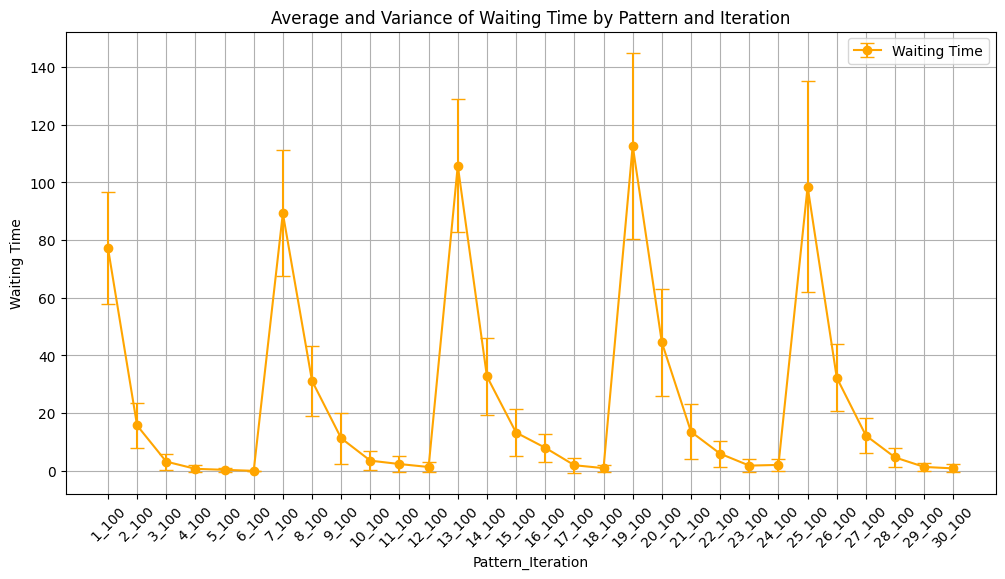

In [43]:
# wating_timeをプロット
plt.figure(figsize=(12, 6))

# 分散のエラーバーを計算
err_wt = np.sqrt(final_df['var_waiting_time'])

plt.errorbar(final_df['label'], final_df['mean_waiting_time'], 
             yerr=err_wt,
             fmt='o-', color='orange', capsize=5, label='Waiting Time')

plt.xlabel('Pattern_Iteration')
plt.ylabel('Waiting Time')
plt.title('Average and Variance of Waiting Time by Pattern and Iteration')
plt.xticks(rotation=45)  # ラベルを45度傾けて表示
plt.legend()
plt.grid(True)
plt.show()

## パラメータDを固定しEの変えていき平均の値のデータ取得後plot

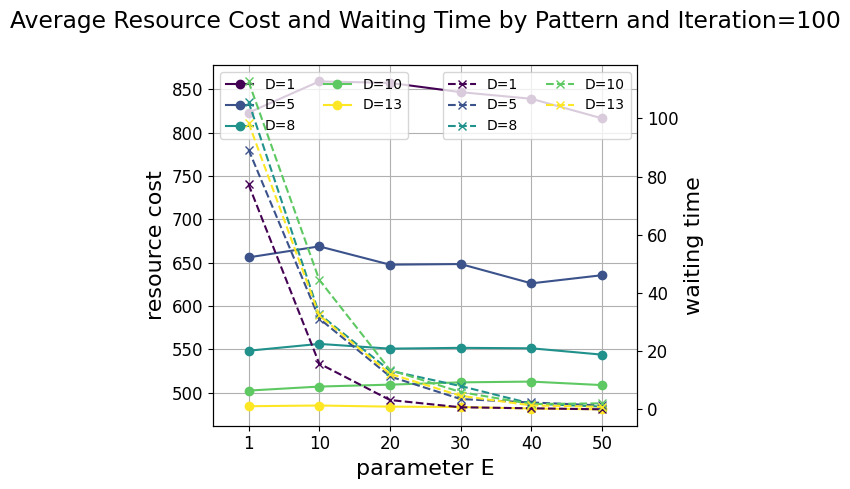

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# プロットの文字サイズを設定
plt.rcParams.update({
    'font.size': 14,          # 全体のフォントサイズ
    'axes.titlesize': 18,     # タイトルのフォントサイズ
    'axes.labelsize': 16,     # X軸、Y軸ラベルのフォントサイズ
    'xtick.labelsize': 12,    # X軸の目盛りラベルのフォントサイズ
    'ytick.labelsize': 12     # Y軸の目盛りラベルのフォントサイズ
})

# 読み込むCSVファイルのリスト
csv_files = [
    '../search/t_30/0901/final_summary_1_to_6.csv',
    '../search/t_30/0901/final_summary_7_to_12.csv',
    '../search/t_30/0901/final_summary_13_to_18.csv',
    '../search/t_30/0901/final_summary_19_to_24.csv',
    '../search/t_30/0901/final_summary_25_to_30.csv'
]

# 凡例のラベルをDの値に対応させる
legend_labels = ['D=1', 'D=5', 'D=8', 'D=10', 'D=13']

# カラーマップを作成（viridisカラーマップを使用）
colors = plt.cm.viridis(np.linspace(0, 1, len(csv_files)))

# カスタムの横軸ラベル
custom_xticks = ['1', '10', '20', '30', '40', '50']

# プロットの作成 - 横幅を狭めるためfigsizeを小さく設定
fig, ax1 = plt.subplots(figsize=(6, 5))  # 横幅6インチ、縦幅5インチ

# 各CSVファイルについてループ
for i, file in enumerate(csv_files):
    final_df = pd.read_csv(file)
    x_indices = np.arange(len(final_df['label']))

    ax1.plot(
        x_indices, 
        final_df['mean_resource_cost'], 
        marker='o', linestyle='-', color=colors[i], 
        label=legend_labels[i]
    )

# 右のY軸を作成
ax2 = ax1.twinx()

# 各CSVファイルについてループ
for i, file in enumerate(csv_files):
    final_df = pd.read_csv(file)
    x_indices = np.arange(len(final_df['label']))

    ax2.plot(
        x_indices, 
        final_df['mean_waiting_time'], 
        marker='x', linestyle='--', color=colors[i], 
        label=legend_labels[i]
    )

# X軸のカスタムラベルを設定
plt.xticks(ticks=np.arange(len(custom_xticks)), labels=custom_xticks, fontsize=12, rotation=45)

# 軸ラベルの設定
ax1.set_xlabel('parameter E')
ax1.set_ylabel('resource cost')
ax2.set_ylabel('waiting time')

# X軸の範囲を調整
ax1.set_xlim(-0.5, len(custom_xticks) - 0.5)

# 余白を調整
ax1.margins(x=0)

# プロットのタイトルを追加
fig.suptitle('Average Resource Cost and Waiting Time by Pattern and Iteration=100')

# 凡例の追加
ax1.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=2, fontsize=10)  # 左側の凡例のフォントサイズ
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=2, fontsize=10)  # 右側の凡例のフォントサイズ

# グリッドを有効化
ax1.grid(True)

# プロットのレイアウトを自動調整し、余白を削除
plt.tight_layout()

# プロットの表示
plt.show()